In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from   scipy.stats import norm
import fsps
import emcee
import corner

# Generate integrated magnitudes using python-fsps

The metallicity of M92 is very low, $[Fe/H]~ -2.15$ which the stellar atmosphere models of Padova, BaSTI and Geneva do not include. In the low metallicity range, PARSEC offers the choice between $[Fe/H]= -2.18$ and $-1.88$ and MIST offers the choice between $[Fe/H] = -2.50$ and $-2.00$. Of these two I decided to use the MIST models. For stellar evolution, I used the default installation of MILES.

The parameters I used to generate the integrated magnitudes are:
1. Distance = 9kpc
2. Age = 14.2Gyr
3. [Fe/H] = -2.00
4. The Cardelli extinction law with Rv = 3.1

In [2]:
def gen_data(filters,sigma):

    print('Initializing Stellar Population..')
    ssp = fsps.StellarPopulation(zmet=2,dust_type=1)
    
    print('Computing magnitude in the V and I bands..')
    mags = ssp.get_mags(tage=14.2,bands=f)
    mags+= -5 + 5*np.log10(9e3) + np.random.normal(loc=0,scale=sigma,size=np.size(f)) + 0.034
    
    return mags

In [29]:
def lnprior(theta):
    """theta = (zmet,age,distance,extinction)"""
    z,age,dist,extin = theta[0],theta[1],theta[2],theta[3]
    if 8 < dist < 10:
        if (5 < age < 15) and (0.001 < extin < 0.2):
            if (-2.50 <= z < -2.25):
                return 1,age,dist,extin
            elif (-2.25 <= z <= -2):
                return 2,age,dist,extin
            else:
                return -np.inf, -np.inf, -np.inf
        else:
            return -np.inf, -np.inf, -np.inf
    else:
        return -np.inf, -np.inf, -np.inf

In [5]:
def lnP(theta,data,ssp,sigma):
    """theta = (zmet,age,distance)"""

    lp = lnprior(theta)
#     print (lp)
    if (np.isfinite(lp)).all() == False:
        return -np.inf
    z,age,dist,ext = lp[0],lp[1],lp[2],lp[3]

    mag = ssp.get_mags(zmet=z,tage=age,bands=f)
    mag+= -5 + 5*np.log10(dist*1e3) + ext
    
    d = norm.logpdf(data,loc=mag,scale=sigma)
    return np.sum(d)

In [30]:
#f = [fsps.find_filter('f606w')[1],fsps.find_filter('f814w')[1]]
f = ['v','cousins_i']
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [31]:
ssp = fsps.StellarPopulation(dust_type=1)
ndim,nwalkers = 4,100
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))

In [32]:
theta0 = np.array([np.random.ranf(ndim) for i in range(nwalkers)])
theta0[:,0] = (-2.5+2)*theta0[:,0]-2.00
theta0[:,1] = (14-5)*theta0[:,1]+5
theta0[:,2] = (10-8)*theta0[:,2]+8
theta0[:,3] = (0.1-0.01)*theta0[:,3]+0.01

In [33]:
sampler.run_mcmc(theta0,100)

(array([[ -2.36671126e+00,   1.40041269e+01,   9.04346872e+00,
           1.50180852e-01],
        [ -2.19459786e+00,   1.32579364e+01,   9.02907104e+00,
           1.50761527e-01],
        [ -2.37191206e+00,   1.20174417e+01,   9.23315753e+00,
           1.23318789e-01],
        [ -2.38934971e+00,   1.20434477e+01,   8.67275146e+00,
           9.71486505e-02],
        [ -2.48153389e+00,   1.46775433e+01,   8.56383802e+00,
           2.56900912e-02],
        [ -2.34835433e+00,   8.00539715e+00,   9.84220626e+00,
           1.70207888e-01],
        [ -2.01934239e+00,   1.43424013e+01,   9.30556583e+00,
           8.61781549e-02],
        [ -2.42970915e+00,   8.39652884e+00,   9.96600943e+00,
           1.49249850e-01],
        [ -2.26944144e+00,   9.38906290e+00,   9.43756500e+00,
           1.48938856e-01],
        [ -2.00993454e+00,   1.38260754e+01,   9.10473866e+00,
           6.03553102e-02],
        [ -2.03660646e+00,   1.43884255e+01,   8.59008748e+00,
           1.39036730e-01],

# Results of $\sigma = 0.1$ errors

The metallicity triangle plot looks like expected- since FSPS allows us to vary metallicity only discreetly between $-2.50$ and $-2.00$, there is no convergent value between that range. Distance and age have more convergent values, though they aren't very close to the actual values.

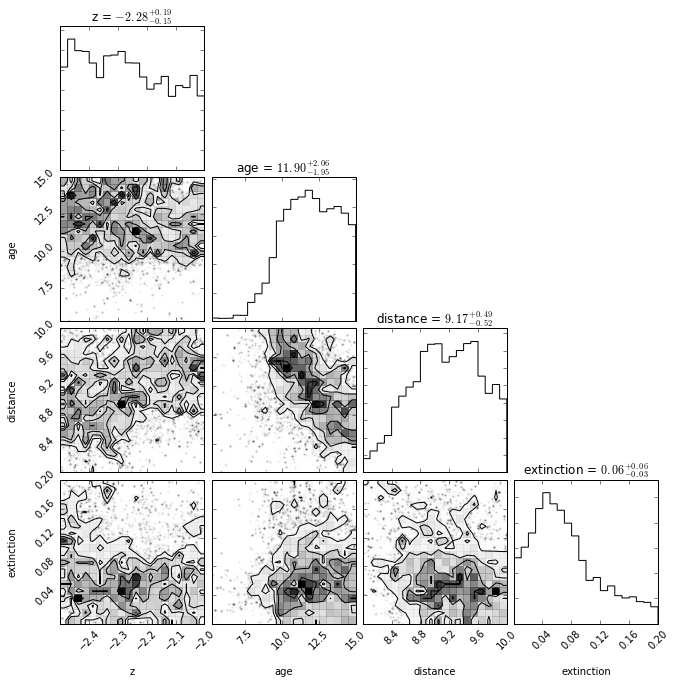

In [34]:
crnr_plt = corner.corner(sampler.flatchain,labels=('z','age','distance','extinction'),show_titles=True)

# Uncertainity of $\sigma = 0.01$

In [11]:
data = gen_data(f,0.01)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [12]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.01))
sampler.run_mcmc(theta0,100)

(array([[ -2.16554432e+00,   1.21486113e+01,   8.72817210e+00,
           1.72341808e-01],
        [ -2.39585907e+00,   1.46570768e+01,   8.41492769e+00,
           4.06414422e-02],
        [ -2.03774534e+00,   1.20616013e+01,   9.29250547e+00,
           3.24894102e-02],
        [ -2.00383239e+00,   1.26621856e+01,   9.84955389e+00,
          -9.54121809e-02],
        [ -2.16374129e+00,   1.11437184e+01,   9.66541126e+00,
          -1.57048337e-02],
        [ -2.27764858e+00,   1.33648270e+01,   8.74146334e+00,
           2.00553507e-02],
        [ -2.10932732e+00,   1.12084838e+01,   9.21734341e+00,
           8.97612849e-02],
        [ -2.23283113e+00,   1.29302767e+01,   9.07755830e+00,
           6.47473938e-02],
        [ -2.20025673e+00,   1.24319097e+01,   8.86052938e+00,
           1.31252757e-01],
        [ -2.30679865e+00,   1.39153030e+01,   8.78511353e+00,
          -1.00687742e-02],
        [ -2.47441304e+00,   1.40727876e+01,   8.73098798e+00,
          -2.40165783e-03],

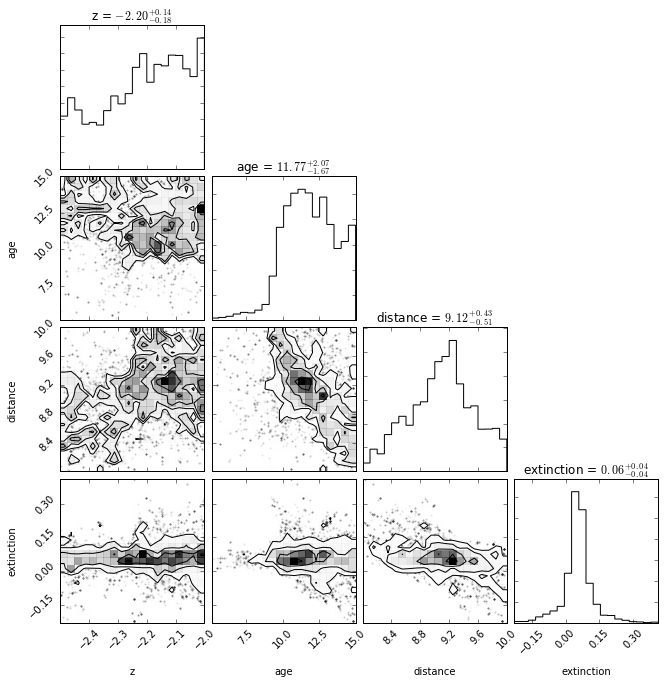

In [14]:
crnr_plt = corner.corner(sampler.flatchain,labels=('z','age','distance','extinction'),show_titles=True)

# UBVI Filters

In [15]:
f = ['v','u','b','cousins_i']
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [16]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))
sampler.run_mcmc(theta0,100)

(array([[ -2.39869391e+00,   1.26506758e+01,   8.28013988e+00,
           2.11746259e-01],
        [ -2.13169053e+00,   1.28108203e+01,   8.85732480e+00,
           1.60657689e-01],
        [ -2.26431761e+00,   1.47938298e+01,   8.69107353e+00,
          -1.01062478e-01],
        [ -2.02890729e+00,   9.91580534e+00,   8.24252475e+00,
           4.14337979e-01],
        [ -2.29519212e+00,   1.14073412e+01,   9.19254606e+00,
           8.78116856e-02],
        [ -2.00091092e+00,   1.06407573e+01,   9.33265471e+00,
           1.85581481e-01],
        [ -2.09657121e+00,   1.08046247e+01,   9.26879226e+00,
           5.50878559e-02],
        [ -2.15788686e+00,   9.53664447e+00,   8.94374078e+00,
           2.08493910e-01],
        [ -2.40223381e+00,   1.43648836e+01,   9.09877106e+00,
          -7.24875730e-02],
        [ -2.21713045e+00,   9.92778383e+00,   9.48120130e+00,
           7.02971360e-02],
        [ -2.02416393e+00,   1.35605259e+01,   9.95213845e+00,
          -2.17501375e-01],

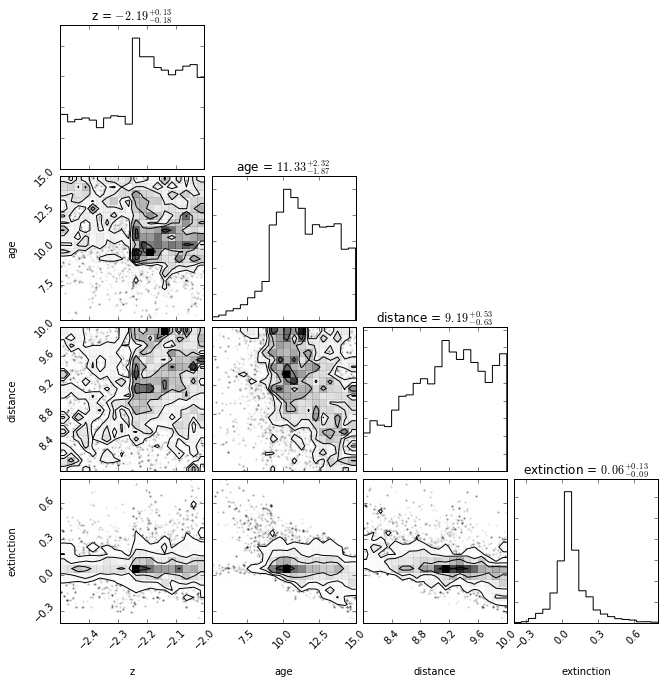

In [18]:
crnr_plt = corner.corner(sampler.flatchain,labels=('z','age','distance','extinction'),show_titles=True)

# Adding Galex FUV Filter

In [35]:
f = ['v','u','b','cousins_i','galex_fuv']
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [26]:
ndim,nwalkers=4,300
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))

In [27]:
sampler.run_mcmc(theta0,100)

(array([[ -2.11393373e+00,   1.39895385e+01,   8.92841477e+00,
           3.49869884e-03],
        [ -2.47847328e+00,   9.99990810e+00,   9.93605450e+00,
           6.22349562e-02],
        [ -2.27550391e+00,   1.03246803e+01,   9.67862822e+00,
           1.21077673e-01],
        ..., 
        [ -2.28067497e+00,   1.01739687e+01,   9.69620857e+00,
           7.52696628e-02],
        [ -2.02219991e+00,   1.42544876e+01,   9.36824687e+00,
           1.37377355e-02],
        [ -2.49051898e+00,   1.00905084e+01,   8.90029243e+00,
           3.18061779e-01]]),
 array([  1.35672634,   3.81413751,   4.01670788,   2.43464626,
          2.67541751,   4.08384333,   4.23603443,   2.10158481,
          4.2936367 ,   3.02735078,   2.2457613 ,  -0.4980442 ,
          3.64689637,   4.03799306,   4.33757617,   4.07797042,
          2.48274696,   4.00913342,   4.08368564,  -0.48682906,
          4.42539528,   3.25853004,   4.67079188,   4.30267644,
          4.39925847,   0.78935742,   3.76299202,   4.

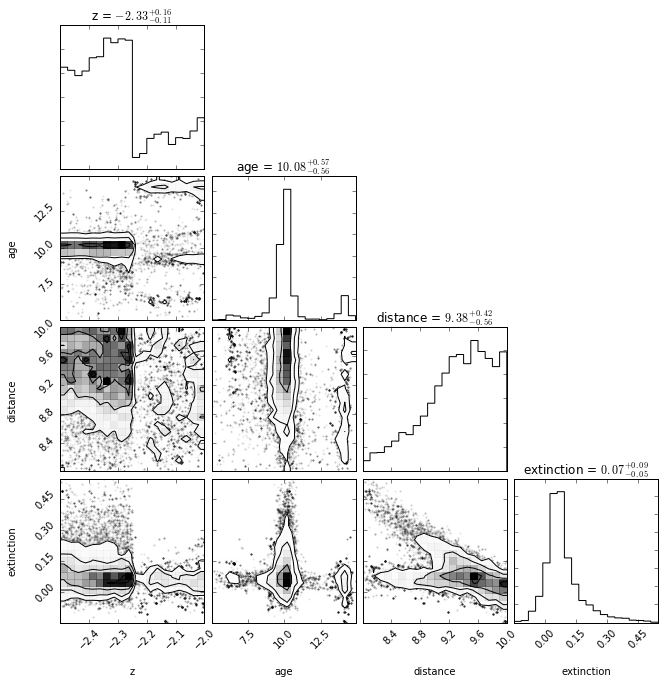

In [28]:
crnr_plt = corner.corner(sampler.flatchain,labels=('z','age','distance','extinction'),show_titles=True)